In [1]:
# import all necessary libraries
import os
from datetime import datetime, timedelta
import requests as r
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
import random
from osgeo import gdal
import re
from tqdm import tqdm
import shutil
import calendar

import rasterio as rio
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.shutil import copy
from rasterio.plot import show

import pyproj
from pyproj import Proj

from shapely.ops import transform
from shapely.geometry import Polygon

# Reservoir Shapefile Correction

In [2]:
res800 = gp.read_file('/scratch/user/anshulya/800_res.geojson')
grand = gp.read_file('/scratch/user/anshulya/gis/grand_conus.geojson')
conus = gp.read_file('/scratch/user/anshulya/gis/s_05mr24/s_05mr24.shp')

In [3]:
for idx, row in tqdm(grand.iterrows(), total = grand.shape[0]):
    x = row['LONG_DD']
    y = row['LAT_DD']
    df_ = res800[(np.absolute(res800['pour_long']-x)<0.01)&(np.absolute(res800['pour_lat']-y)<0.01)]
    if df_.shape[0] == 1:
        polygon1 = row['geometry']
        polygon2 = df_['geometry'].values[0]

        a1 = polygon1.area
        a2 = polygon2.area

        if a1!=a2:
            union_polygon = row['geometry'].union(df_['geometry'].values[0])
            grand.loc[idx,'geometry'] = union_polygon
    else:
        gid = row['GRAND_ID']
        df_ = res800[res800['grand_id']==gid]
        if df_.shape[0] == 1:
            polygon1 = row['geometry']
            polygon2 = df_['geometry'].values[0]
    
            a1 = polygon1.area
            a2 = polygon2.area
    
            if a1!=a2:
                union_polygon = row['geometry'].union(df_['geometry'].values[0])
                grand.loc[idx,'geometry'] = union_polygon        

100%|██████████| 1907/1907 [00:06<00:00, 285.72it/s]


In [40]:
for idx, row in grand[grand['CAP_MAX']<grand['CAP_REP']].iterrows():
    print(row['RES_NAME'], row['CAP_MAX'], row['CAP_REP'])

  -99.0 37.6
Lewiston Reservoir -99.0 115.0
Lake Saint Lawrence -99.0 807.9
Blandin Reservoir -99.0 4.9
Garden Lake Reservoir -99.0 216.7
Lake Nighthorse -99.0 148.0
Wilson Lake -99.0 789.7
Lake Pleasant -99.0 1311.4
Richard B. Russell Lake -99.0 1835.6
Salmon Creek Falls Reservoir -99.0 284.5
Carlyle Lake -99.0 1571.1
Elk City Lake -99.0 1049.0
Green Lake -99.0 132.0
Moore Lake -99.0 276.0
  -99.0 277.5
Sardis Lake -99.0 907.6
Tims Ford Lake -99.0 750.0
Cordell Hull Lake -99.0 383.5
  -99.0 520.5
  -99.0 115.4


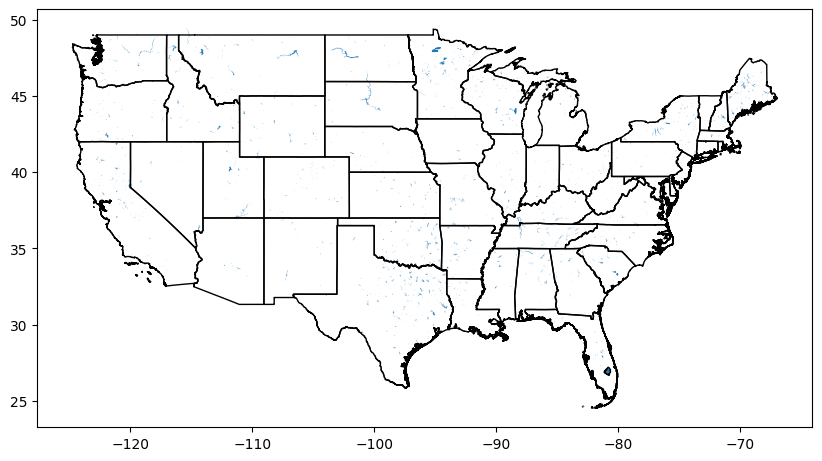

In [4]:
fig, ax = plt.subplots(1,1,figsize=(10,7))
grand.plot(ax = ax)
conus.plot(ax = ax, facecolor='none', ec = 'k')
plt.show()

In [14]:
grand.to_file("/scratch/user/anshulya/gis/hls_reservoirs.geojson", driver='GeoJSON')

# Sentinel Tiles for small reservoirs

In [15]:
s2_res = pd.read_csv('/scratch/user/anshulya/gis/sentinel_tiles.csv')

In [16]:
# Group by 'GRAND_ID' and count unique names
unique_names_per_id = s2_res.groupby('GRAND_ID')['Name'].nunique()

# Filter to get 'GRAND_ID's with only one unique name
grand_ids_with_unique_names = unique_names_per_id[unique_names_per_id == 1].index

In [17]:
filtered_df = grand[grand['GRAND_ID'].isin(grand_ids_with_unique_names)]

In [18]:
for idx, row in filtered_df.iterrows():
    filtered_df.loc[idx, 's2-tile'] = s2_res.loc[s2_res['GRAND_ID']==row['GRAND_ID'], 'Name'].values[0]

/home/anshulya/.local/lib/python3.11/site-packages/geopandas/geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [19]:
len(filtered_df['s2-tile'].unique())

442

In [35]:
list(filtered_df[filtered_df['s2-tile']=='13TDE']['GRAND_ID'])

[474,
 476,
 478,
 480,
 481,
 486,
 487,
 490,
 491,
 492,
 495,
 498,
 499,
 500,
 501,
 504,
 505]

In [20]:
grouped = filtered_df.groupby('s2-tile').size()

# Sort the groups by size in descending order
sorted_grouped = grouped.sort_values(ascending=False)

# Print the result
print(sorted_grouped)

s2-tile
13TDE    17
18TWL    14
19TDL    11
18TXM    11
17RMM    10
         ..
18TVQ     1
11SNT     1
11SPD     1
11SQS     1
11TLL     1
Length: 442, dtype: int64


In [31]:
list(sorted_grouped[sorted_grouped>=5].index)

['13TDE',
 '18TWL',
 '19TDL',
 '18TXM',
 '17RMM',
 '14SPB',
 '11SMT',
 '18TWQ',
 '14TQS',
 '18TXL',
 '10SFJ',
 '15TVN',
 '19TCJ',
 '15TWN',
 '18TYP',
 '17RML',
 '11SNS',
 '11SLB',
 '18TVL',
 '17RLL',
 '13TEE',
 '13SDD',
 '12TVL',
 '16TDS',
 '17TME',
 '17TLE',
 '17SNV',
 '10SEH',
 '10TES',
 '10SEG',
 '14SPE',
 '15SUD',
 '10TFK',
 '10TEL',
 '12SVC',
 '19TDK',
 '10TEP',
 '15TVM',
 '14SNB',
 '15SUA',
 '13TDF',
 '19TEL',
 '17SMV',
 '12SVJ',
 '10TER',
 '19TDM',
 '10SFG',
 '10SFH',
 '15RWQ',
 '15SUS',
 '13SFC',
 '16TCL',
 '11SLU',
 '16SEJ',
 '10TEM',
 '17TNF',
 '16TCN',
 '18TWM']